# Visium HD dataset

In [27]:
#! /opt/homebrew/bin/python3 -m pip install scanpy

In [28]:
import scanpy as sc
import spatialdata as sd
from spatialdata import bounding_box_query
from spatialdata_io.experimental import to_legacy_anndata

import matplotlib.pyplot as plt

plt.style.use('dark_background')

from pathlib import Path


In [34]:
# More fleshed out code

dataset_id = "8dcfc3f6-1965-49b0-be49-e2e4d7236897"

spatial_path = Path("../www/datasets/spatial")
zarr_path = spatial_path / f"{dataset_id}.zarr"
if not zarr_path.exists():
    raise ValueError(f"Dataset {dataset_id} not found")
sdata = sd.read_zarr(zarr_path)

# Create AnnData object
# Need to include image since the bounding box query does not filter the image data by coordinates
# Each Image is downscaled (or upscaled) during rendering to fit a 2000x2000 pixels image (downscaled_hires)
adata = to_legacy_anndata(sdata, include_images=True, coordinate_system="downscaled_hires", table_name="table")

# Filter out cells that overlap with the blank space of the image.
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

adata.var_names_make_unique()

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

vis_adata = adata

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[0.33170463 0.         2.58838345]                                                                
          [0.         0.33175501 6.27193005]                                                                       
          [0.         0.         1.        ]]                                                                      
         eigenvalues=[0.33170463 0.33175501]                                                                       
         scale_factor=0.3317298215187157                                                                           
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

In [35]:
#marker_genes = ["Pou4f3", "Calb2", "Pvalb", "Smpx", "Mlf1", "Sox2", "Atoh1"]  # 5 random Cochlear HCs P7 + Sox2 and Atoh1

# Slc26a5 and Ocm are great for outer hair cells.
# Slc17a8 and Otof are good markers for inner hair cells.
# Ptprq and Fcrlb are good for both hair cell types.
marker_genes = ["Slc26a5", "Ocm", "Slc17a8", "Otof", "Ptprq", "Fcrlb"]

def normalize_marker_genes(gene_list, chosen_genes):
    """Convert to case-insensitive.  Also will not add chosen gene if not in gene list."""
    case_insensitive_genes = [g for cg in chosen_genes for g in gene_list if cg.lower() == g.lower()]
    return case_insensitive_genes

# Reset index to gene symbol to ensure gene names are the plot labels
vis_adata.var.reset_index(inplace=True)
vis_adata.var.set_index('gene_symbol', inplace=True)

# Deduplicate gene_symbols
vis_adata = vis_adata[:, vis_adata.var.index.duplicated() == False]

vis_adata.var_names_make_unique()
gene_symbols = vis_adata.var.index.tolist()
marker_genes = normalize_marker_genes(gene_symbols, marker_genes)

num_genes = len(marker_genes)
marker_genes

['Slc26a5', 'Ocm', 'Slc17a8', 'Otof', 'Ptprq', 'Fcrlb']

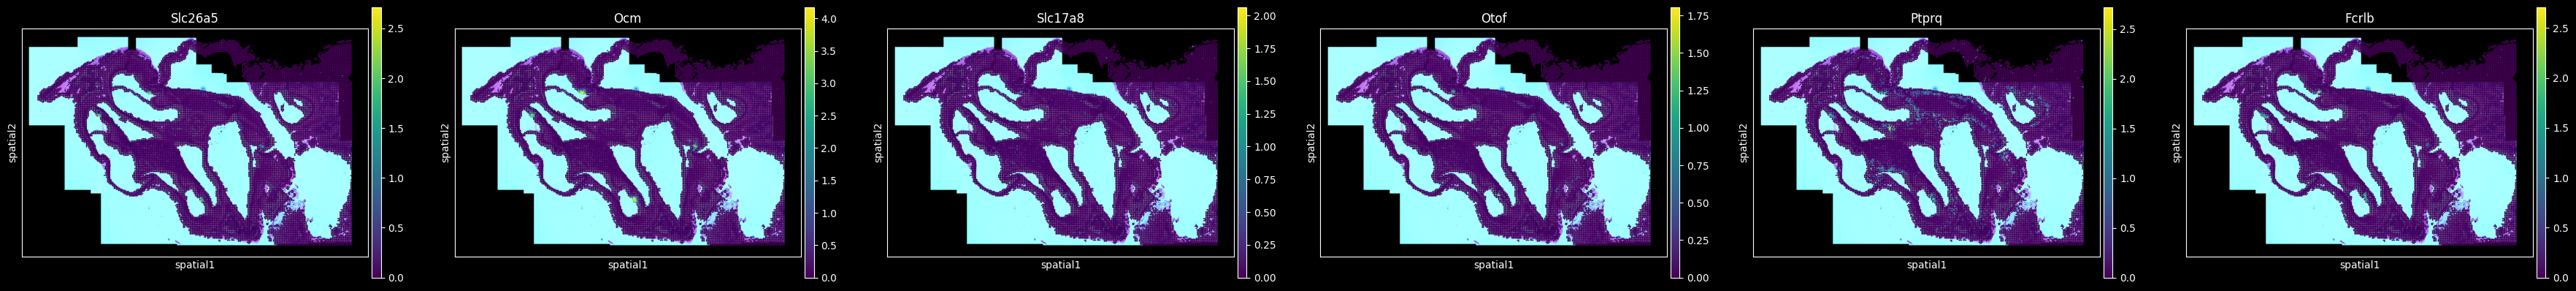

In [36]:
leiden2_ax = sc.pl.spatial(vis_adata, img_key="hires", color=marker_genes, size=1, library_id="spatialdata_hires_image", ncols=num_genes, show=False)

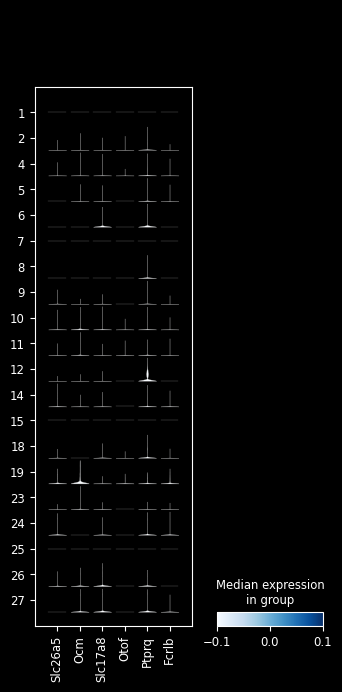

In [37]:
violin_ax = sc.pl.stacked_violin(vis_adata, marker_genes, groupby="clusters", use_raw=False, show=False)

[<Axes: title={'center': 'clusters'}, xlabel='spatial1', ylabel='spatial2'>]

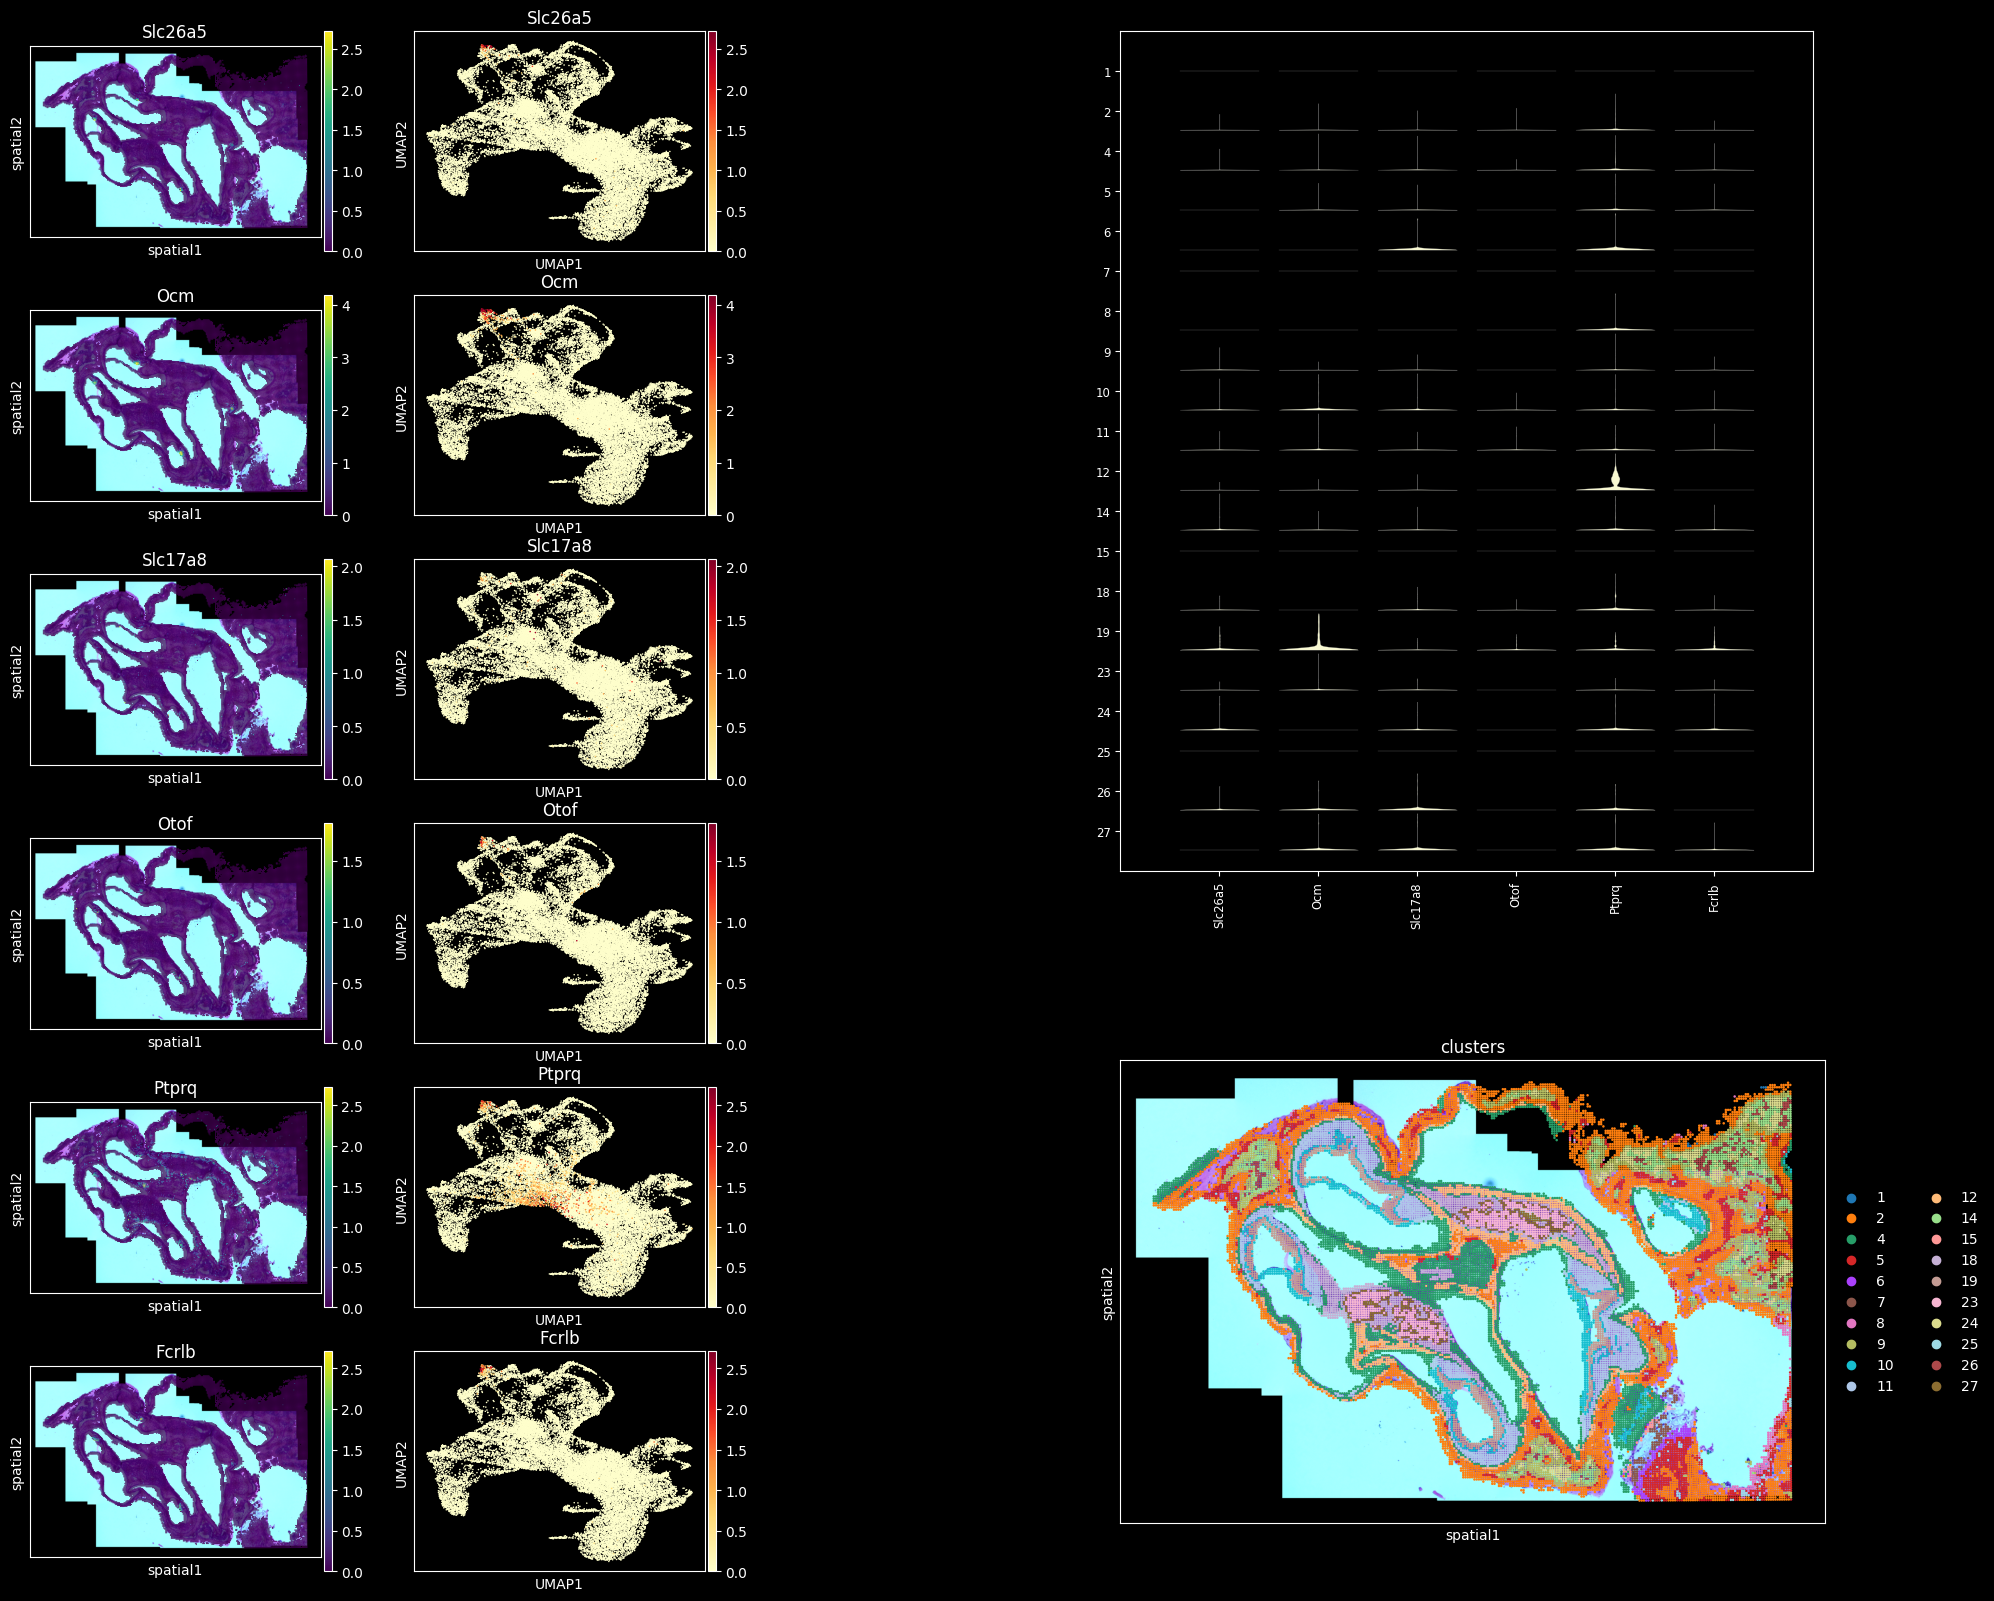

In [38]:
# DRAFT 1
from matplotlib import pyplot as plt

# Split into 2 subfigures.  Left side will be "per-gene" plots, and right side will be "per-cluster" plots
fig = plt.figure(figsize=(20, 20))
subfigs = fig.subfigures(1, 2, wspace=0.2)

ax0 = subfigs[0].subplots(num_genes, 2)
ax_row = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="spatialdata_hires_image", ax=ax0[ax_row][0], show=False)
    sc.pl.umap(vis_adata, color=gene, ax=ax0[ax_row][1], color_map="YlOrRd", show=False)
    ax_row +=1

ax1, ax2 = subfigs[1].subplots(nrows=2, ncols=1, height_ratios=[0.6, 0.4])

violin_fig = sc.pl.stacked_violin(vis_adata, marker_genes, groupby="clusters", ax=ax1, cmap="YlOrRd", show=False, return_fig=True, figsize=(20, 20))
# Remove the existing legend and add a new vertically-oriented one
violin_fig.legend(show = False)
violin_fig.make_figure()
#plt.colorbar(violin_fig, cax=ax1.inset_axes([0.95, 0.1, 0.05, 0.8]), ax=ax1, orientation="vertical")

sc.pl.spatial(vis_adata, img_key="hires", color="clusters", size=1, library_id="spatialdata_hires_image", ax=ax2, show=False)


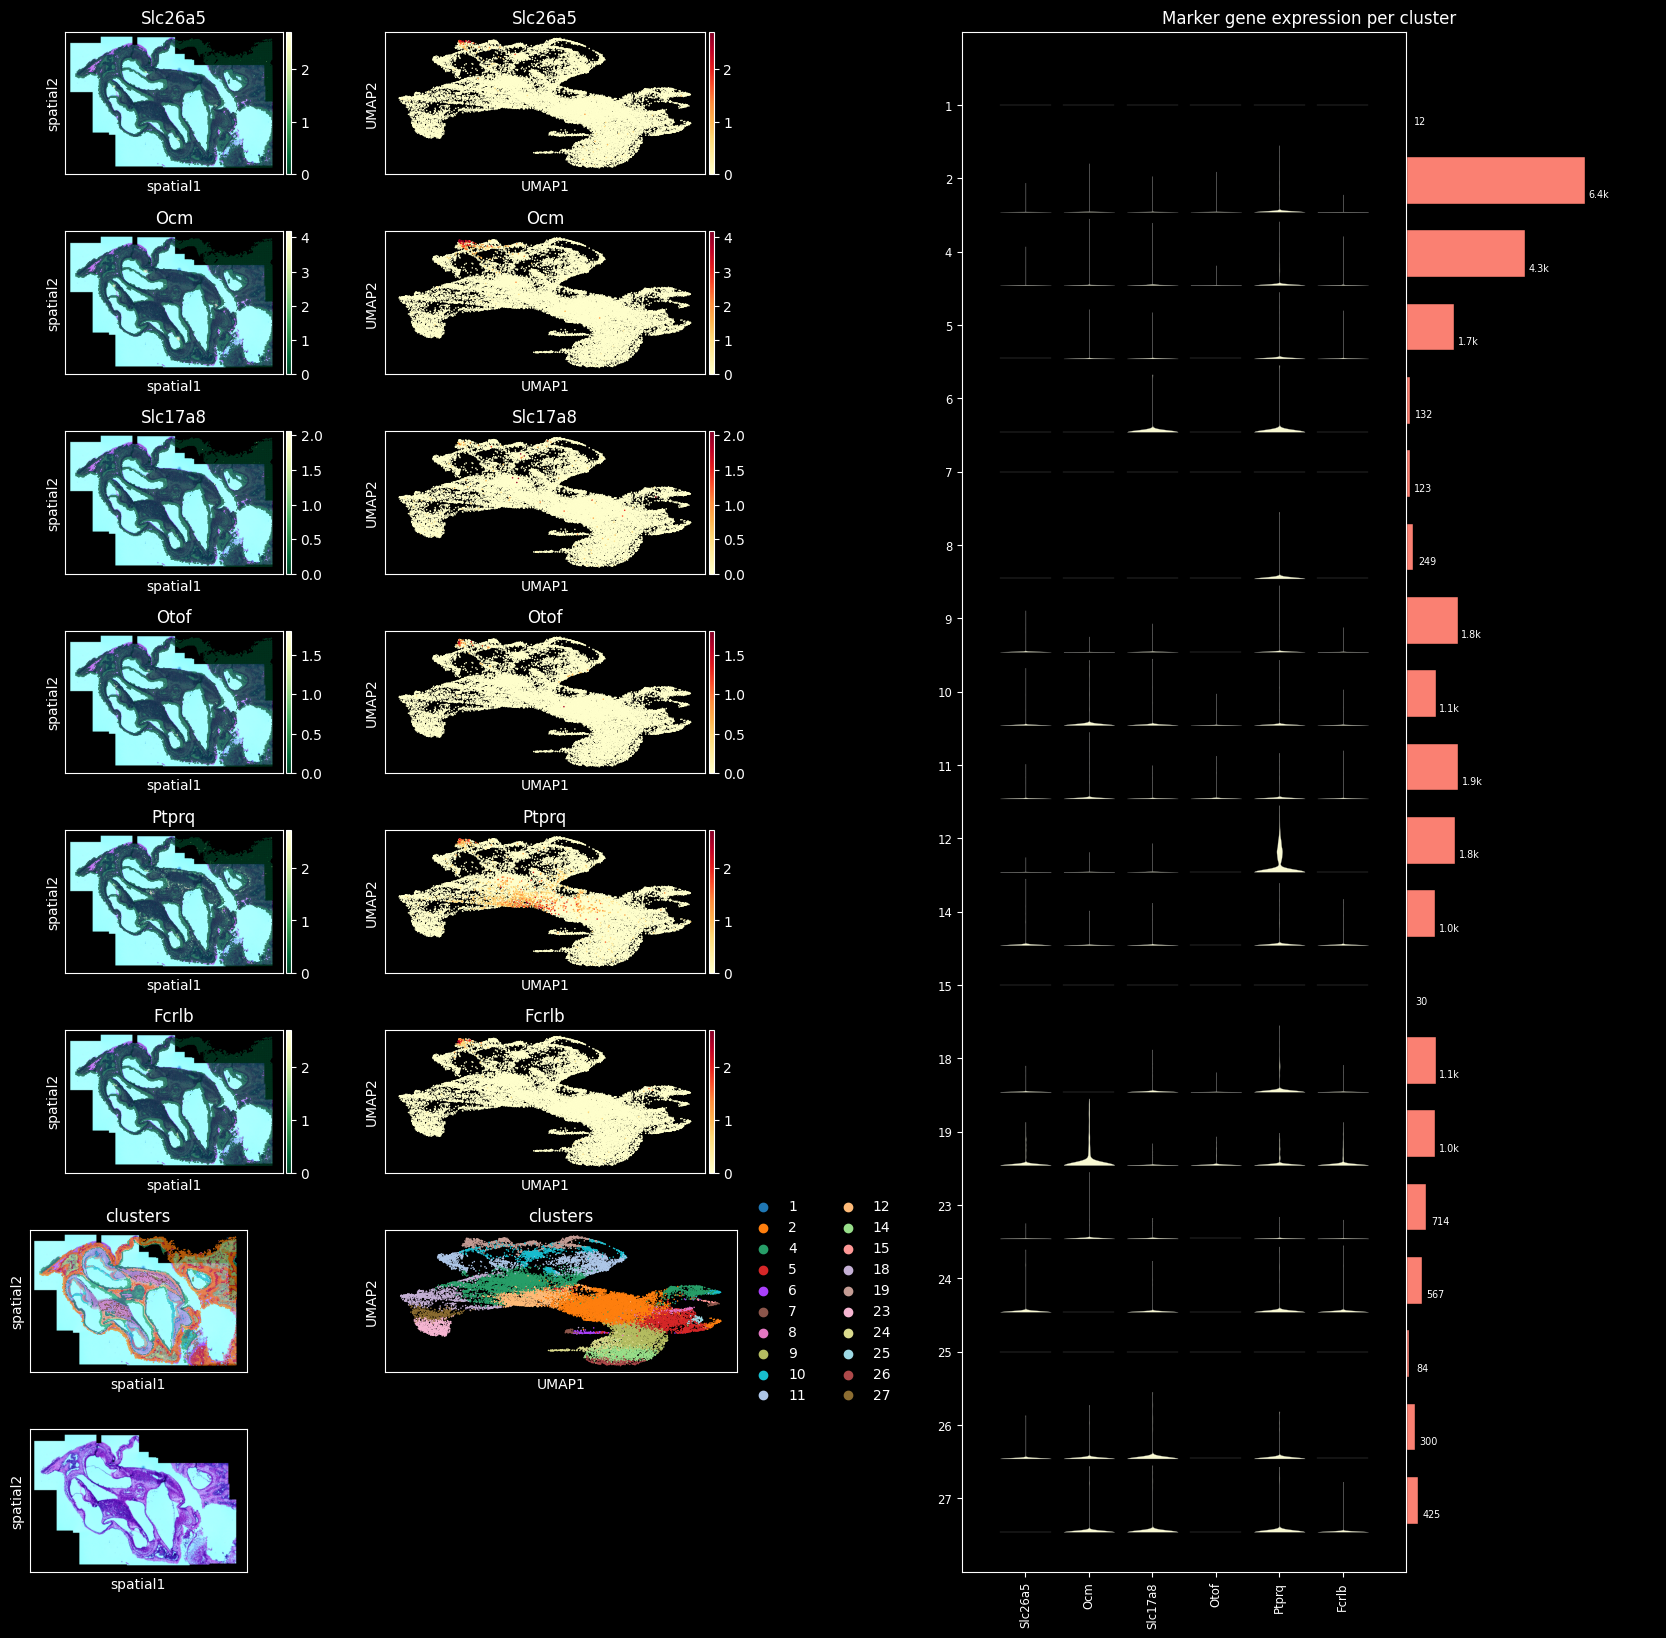

In [39]:
# DRAFT 2 (based on feedback on draft 1)

# Split into 2 subfigures.  Left side will be "per-gene" plots, and right side will be "per-cluster" plots
fig = plt.figure(figsize=(20, 20))
subfigs = fig.subfigures(1, 2)

subfigs[0].subplots_adjust(hspace=0.4)

ax0 = subfigs[0].subplots(num_genes+2, 2)
ax_row = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="spatialdata_hires_image", ax=ax0[ax_row][0], color_map="YlGn_r", show=False)
    sc.pl.umap(vis_adata, color=gene, ax=ax0[ax_row][1], color_map="YlOrRd", show=False)
    ax_row +=1

# clusters
sc.pl.spatial(vis_adata, img_key="hires", color="clusters", size=1, library_id="spatialdata_hires_image", legend_loc=None, ax=ax0[ax_row][0], show=False)
sc.pl.umap(vis_adata, color="clusters", ax=ax0[ax_row][1], color_map="YlOrRd", show=False)

# align ax0[ax_row][0] with the plots above
ax0[ax_row][0].set_anchor("C")

ax_row +=1

# blank image
sc.pl.spatial(vis_adata, img_key="hires", color=None, size=1, library_id="spatialdata_hires_image", ax=ax0[ax_row][0], show=False)
ax0[ax_row][0].set_anchor("C")

# remove axes for ax0[ax_row][1]
ax0[ax_row][1].axis("off")

# Stacked Violin plot
ax1 = subfigs[1].subplots(nrows=1, ncols=1)

violin_fig = sc.pl.stacked_violin(vis_adata, marker_genes, title="Marker gene expression per cluster", groupby="clusters", cmap="YlOrRd", ax=ax1, show=False, return_fig=True)

# Remove the existing legend and add a new vertically-oriented one
violin_fig.legend(show = False)
violin_fig.add_totals()
violin_fig.make_figure()

violin_axes = violin_fig.fig.get_axes()

# For some reason, deleting all axes and remaking the figure makes it without the spacer above the plot (which was in ax[2] I think)
for ax in violin_axes:
    violin_fig.fig.delaxes(ax)

violin_fig.make_figure()



TypeError: object of type 'int' has no len()

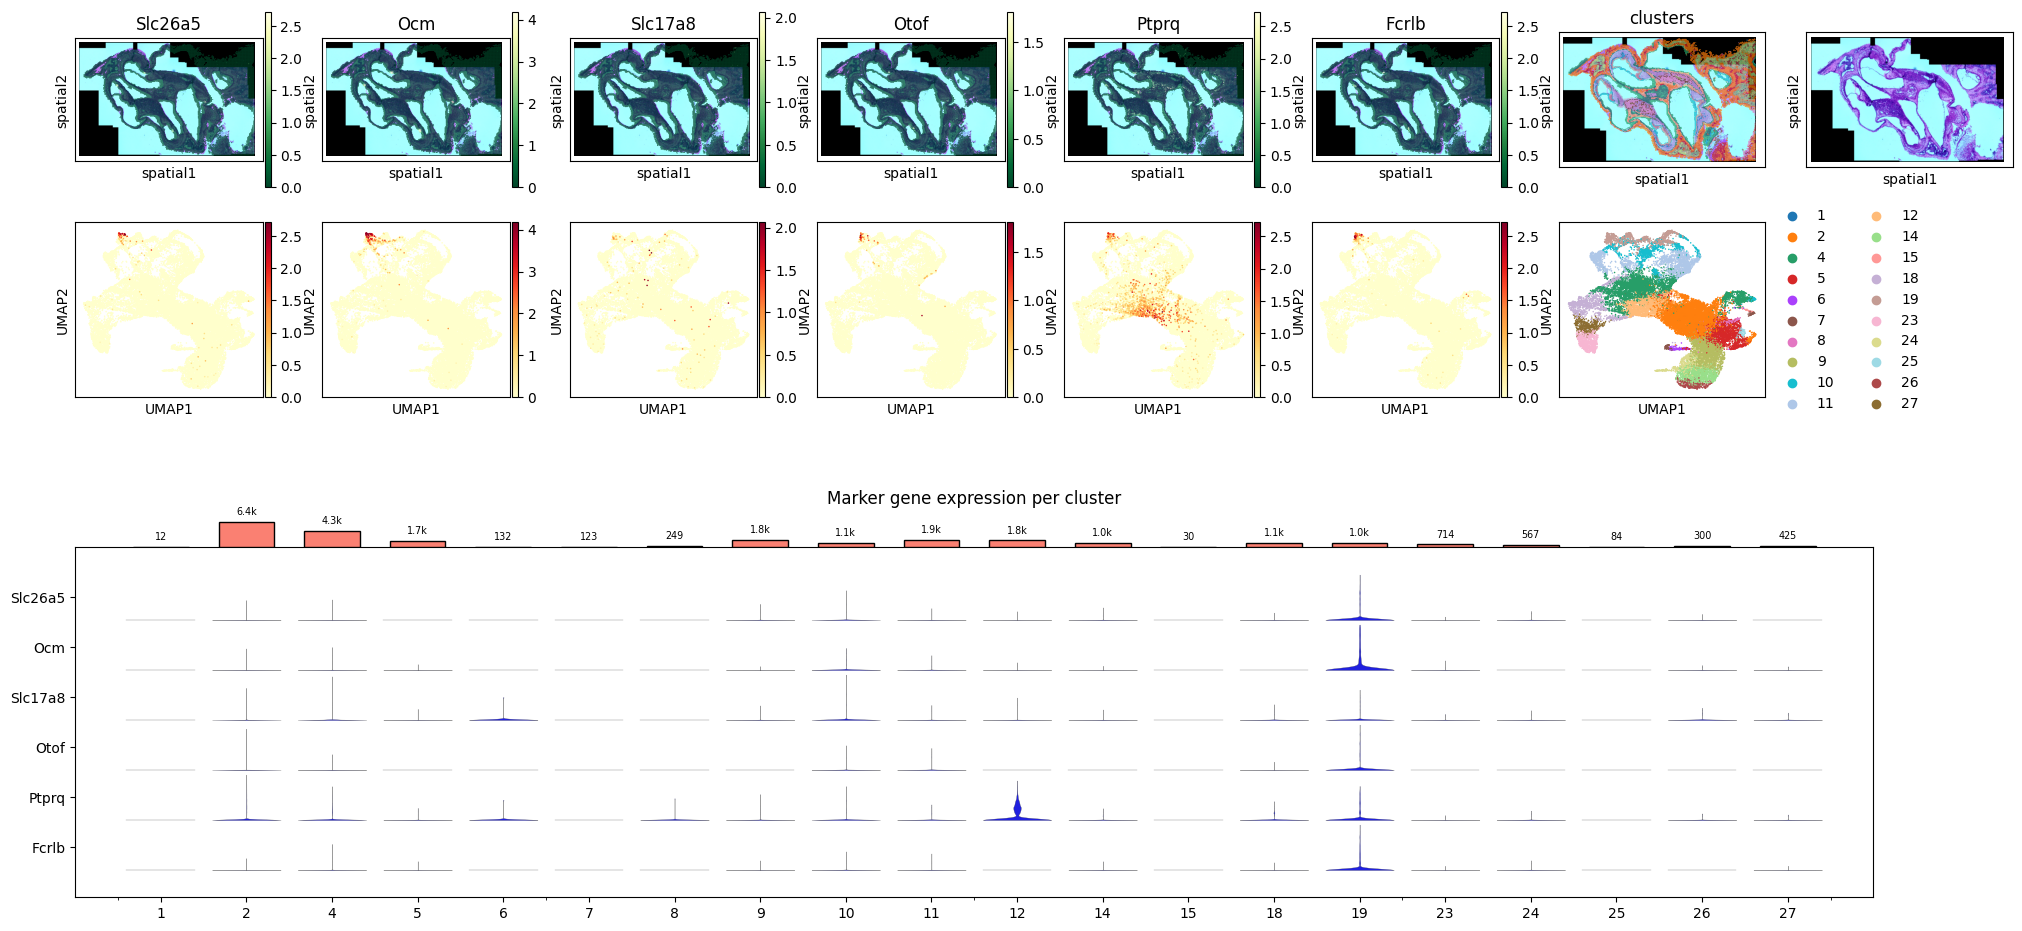

In [42]:
#4th iteration

plt.style.use('default')

# Split into 2 top/bottom subfigures.  Top side will be spatial and umap plots, and bottom side will be "stacked violin" plot
fig = plt.figure(figsize=(25, 10))

subfigs = fig.subfigures(2,1)

#subfigs[0].subplots_adjust(hspace=0.5)

ax0 = subfigs[0].subplots(2, num_genes+2)
ax_col = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="spatialdata_hires_image", ax=ax0[0][ax_col], color_map="YlGn_r", show=False)
    sc.pl.umap(vis_adata, color=gene, ax=ax0[1][ax_col], color_map="YlOrRd", na_color="gray", show=False)

    # remove umap title (using title=None doesn't work)
    ax0[1][ax_col].set_title("")
    ax_col +=1

# clusters
sc.pl.spatial(vis_adata, img_key="hires", color="clusters", size=1, library_id="spatialdata_hires_image", legend_loc=None, ax=ax0[0][ax_col], show=False)
sc.pl.umap(vis_adata, color="clusters", ax=ax0[1][ax_col], show=False)

# remove umap title (using title=None doesn't work)
ax0[1][ax_col].set_title("")
ax_col +=1

# blank image
sc.pl.spatial(vis_adata, img_key="hires", color=None, size=1, library_id="spatialdata_hires_image", ax=ax0[0][ax_col], show=False)

# remove axes for ax0[ax_row][1]
ax0[1][ax_col].axis("off")

# Stacked Violin plot
ax1 = subfigs[1].subplots(nrows=1, ncols=1)

violin_fig = sc.pl.stacked_violin(vis_adata, marker_genes, title="Marker gene expression per cluster", groupby="clusters", ax=ax1, row_palette="Blue", show=False, return_fig=True)

# Remove the existing legend and add a new vertically-oriented one
violin_fig.add_totals()
violin_fig.make_figure()

violin_axes = violin_fig.fig.get_axes()

# For some reason, deleting all axes and remaking the figure makes it without the spacer above the plot (which was in ax[2] I think)
for ax in violin_axes:
    violin_fig.fig.delaxes(ax)

violin_fig.swap_axes()
violin_fig.make_figure()

In [ ]:
#4th iteration

plt.style.use('default')

# Split into 2 top/bottom subfigures.  Top side will be spatial and umap plots, and bottom side will be "stacked violin" plot
fig = plt.figure(figsize=(30, 12))

subfigs = fig.subfigures(2,1)

#subfigs[0].subplots_adjust(hspace=0.5)

ax0 = subfigs[0].subplots(2, num_genes+2)
ax_col = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="spatialdata_hires_image", ax=ax0[0][ax_col], color_map="YlGn_r", show=False)
    sc.pl.umap(vis_adata, color=gene, ax=ax0[1][ax_col], color_map="YlGn_r", na_color="gray", show=False)

    # remove umap title (using title=None doesn't work)
    ax0[1][ax_col].set_title("")
    ax0[1][ax_col].set_facecolor("#000000")
    ax_col +=1

# clusters
sc.pl.spatial(vis_adata, img_key="hires", color="Clusters", library_id="spatialdata_hires_image", legend_loc=None, ax=ax0[0][ax_col], show=False)
sc.pl.umap(vis_adata, color="Clusters", ax=ax0[1][ax_col], show=False)

# remove umap title (using title=None doesn't work)
ax0[1][ax_col].set_title("")
ax0[1][ax_col].set_facecolor("#000000")
ax_col +=1

# blank image
sc.pl.spatial(vis_adata, img_key="hires", color=None, library_id="spatialdata_hires_image", ax=ax0[0][ax_col], show=False)

# remove axes for ax0[ax_row][1]
ax0[1][ax_col].axis("off")

# Stacked Violin plot
ax1 = subfigs[1].subplots(nrows=1, ncols=1)

dotplot_fig = sc.pl.dotplot(vis_adata, marker_genes, title="Marker gene expression per cluster", groupby="Clusters", ax=ax1, swap_axes=True, cmap="YlGn_r", show=False, return_fig=True)
dotplot_fig.make_figure()

dotplot_axes = dotplot_fig.fig.get_axes()

# For some reason, deleting all axes and remaking the figure makes it without the spacer above the plot (which was in ax[2] I think)
for ax in dotplot_axes:
    dotplot_fig.fig.delaxes(ax)

dotplot_fig.make_figure()
#dotplot_fig.get_axes()["mainplot_ax"].patch.set_facecolor("white")

